# 1 Importing libraries and loading data

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error

np.seterr(divide='ignore', invalid='ignore')

# useful function to load CIFAR-10 datasets
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [83]:
# loading datasets

# fashion MNIST
fashion_mnist_train = pd.read_csv("./datasets/fashion-mnist_train.csv") 
fashion_mnist_test = pd.read_csv("./datasets/fashion-mnist_test.csv")

# CIFAR-10 train
baseName = "./datasets/cifar-10-batches-py/data_batch_"
X_train = np.array([row for batch in [unpickle(baseName + str(i))[b'data'] for i in range(1, 6)] for row in batch])
y_train = np.array([label for batch in [unpickle(baseName + str(i))[b'labels'] for i in range(1, 6)] for label in batch])
cifar10_train = pd.DataFrame(X_train)
cifar10_train["class"] = y_train

# CIFAR-10 test
X_test = unpickle("./datasets/cifar-10-batches-py/test_batch")[b'data']
y_test = unpickle("./datasets/cifar-10-batches-py/test_batch")[b'labels']
cifar10_test = pd.DataFrame(X_test)
cifar10_test["class"] = y_test

# 2 Data analysis

# 2.1 Fashion MNIST analysis

In [84]:
fashion_mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
print("Fashion MNIST - number of rows:", len(fashion_mnist_train))

Fashion MNIST - number of rows: 60000


<div class="alert alert-success">
<b>Fashion MNIST - General overview</b><br>
From the previous results we can see that we have a training set with 60000 rows: a large amount of data in order to (potentially) have a good training. The dimensionality is high: 785 features. This is a problem for many models but in this case we are going to use Naïve Bayes that is really good at dealing with this fact (in the next section we'll discover why). 
</div>

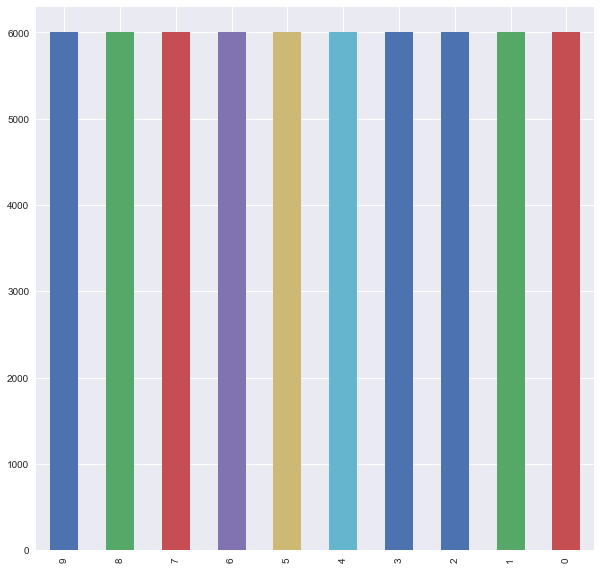

In [86]:
plt.figure(figsize=(10,10))
pd.value_counts(fashion_mnist_train['label']).plot.bar()

<div class="alert alert-success">
<b>Fashion MNIST - About the class distribution</b><br>
It is really important taking a look at class distribution because based on this analysis we should take a decision on our prior (see next section for better explanation on Naïve Bayes). In this case we can see that we have the same number of instaces for each class so we can conclude that there is no prior preference; in other words we can assume that the prior distribution is uniform: each class has P(t_new = Class) = 1 / K, where K is the number of classes.
</div>

# 2.2 CIFAR-10 analysis

In [87]:
cifar10_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,class
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


In [88]:
print("CIFAR-10 - number of rows:", len(cifar10_train))

CIFAR-10 - number of rows: 50000


<div class="alert alert-success">
<b>CIFAR-10 - General overview</b><br>
From the previous results we can see that we have a training set with 50000 rows. The dimensionality is really high, more than before: 3073 features. Again, with Naïve Bayes is perfect in this case (under the point of view of computational cost) but of course we don't know if all the attributes are independent. We'll see looking at performance metrics. 
</div>

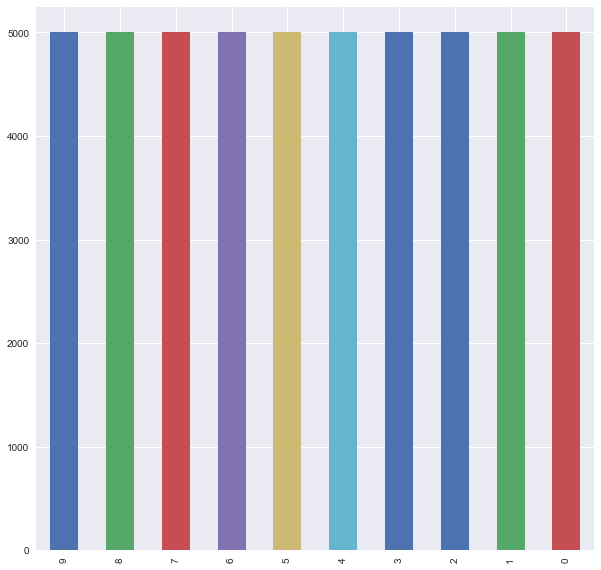

In [89]:
plt.figure(figsize=(10,10))
pd.value_counts(cifar10_train['class']).plot.bar()

<div class="alert alert-success">
<b>CIFAR-10 - About the class distribution</b><br>
Even in this case we have the same number of instaces for each class. Therefore the prior distribution is again uniform: each class has P(t_new = Class) = 1 / K, where K is the number of classes.
</div>

# 2.3 Pre-processing suggestions

<div class="alert alert-success">
When we talk about data pre-processing we immediately think about outliers, feature engineering and dimensionality reduction.<br><br>

About the first one in this case we can't say too much in this notebook: for sure there is a lot of research out there about outlier-removal in image-classification but it is about image processing, therefore out of scope of this assignment.<br><br>

About feature engineering a easy-to-do operation is scaling, which speed-up our algorithms. All the values we are dealing are between 0 and 255 (grayscale images), so we can simply use a scale from 0 to 1. An alternative to this approach could be converting all the images in Black/White in order to have only 0 or 1 as values, simplyfing the features.<br><br>

Dimensionality reduction could be a good thing, we have really high dimensional data. The first technique we may think is PCA (Principal Component Analysis). At first glance it seems a good idea because we will obtain uncorrelated features and it is the best case for Naïve Bayes. It's actually problematic: it does NOT CARE AT ALL about labels. It simply finds the directions where most of the variance is explained, but it could make our classification problem much more difficult. In the following image is showed a simple classification problem: detect photos of cats and dogs; the class instances are linearly separable (left-side) but they are distributed in a certain way that after PCA (right-side) they are not.<br>
<img src="http://www.visiondummy.com/wp-content/uploads/2014/05/pca_lda.png"><br>
We should use LDA (Linear Discriminant Analysis) but in this case we are talking about another model, i.e. supervised learning. We will talk in the section 3.4.2.
</div>

# 3 Classification

## 3.1 Naïve Bayes implementation

<div class="alert alert-success">
<b>Naïve Bayes: the goal</b><br>
In this classification model we would compute, given the input x, the probability that it belongs to class C_k. But in many cases this task is unfeasible, for this reason we use the Bayes theorem to solve the problem from another point of view.
</div>

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/52bd0ca5938da89d7f9bf388dc7edcbd546c118e">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b0122d84d632cc399d2a49924797f37a7db53b0c">

<div class="alert alert-success">
<b>Naïve Bayes: how to proceed</b><br>
As showed in the last pictures, we should define a prior and compute the likelihood in order to get what we are looking for. From the previous analysis we have decided that the prior is a uniform distribution, where each class has probability 1/K. In the case of likelihood we suppose that attributes have normal distribution, so we can easily compute the likelihood for each attribute with this formula:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/685339e22f57b18d804f2e0a9c507421da59e2ab">
</div>

<div class="alert alert-success">
<b>Naïve Bayes: pros and cons</b><br>
This model is really easy to implement and computationally fast, especially when we are dealing with large amout of data with high dimensionality (like in our case). The other side of the coin is the model makes a strong assumption: <u>independence among features</u>; for this reason it is called "naïve". This assumption brings all the advantages which I talked about before but at the same time we should care if it is (quite) true in our data. If it is not, probably we'll have poor results.<br><br>

Making this assumption our life is easy: in order to compute p(x | C_k) we can simply compute the likelihood for each attribute and multiply them to obtain the likelihood for a specific class. At the end we simply choose the most likely:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/5ed52009429e5f3028302427a067822fdfc58059">
</div>

In [151]:
class NaiveBayes:
    def __init__(self, priors=None):
        self.noise = 0.0001
        self.priors = priors
    
    def fit(self, X, y):
        # separate rows by target class
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        
        # for all the rows belonging to the same class compute the mean and std dev for each attribute
        # obtaining two matrices nb of classes x nb of features
        # adding some noise in stds to avoid instability (division by zero problem)
        self.means = np.array([np.mean(g, axis=0) for g in separated])
        self.stds = np.array([np.std(g, axis=0) for g in separated]) + self.noise
        
        # check if the prior is set otherwise assume uniform
        if self.priors is not None:
            if len(self.priors) != len(self.means):
                raise ValueError('The lenght of priors is not equal to the number of classes in your data')
        else:
            self.priors = np.repeat(1 / len(self.means), len(self.means))
              
    def predict(self, X, return_likelihoods=False):
        # for each row apply the function that compute the likelihood for each class and return the best one
        self.return_likelihoods = return_likelihoods
        return np.apply_along_axis(self.predict_class_by_row, 1, X)
        
    def predict_class_by_row(self, row):
        # apply normal pdf in matrix form
        # for each row (number of classes) we got the log(likelihood) for an attribute in that class
        # using the log in order to avoid instability because of too small values
        # instead of np.prod use np.sum thanks to log operation
        # summing by row (independent attributes) we obtain the log(likelihood) for the i-th class
        # return that with higher posterior
        P = np.sum(np.log(1 / (2 * self.stds * np.sqrt(2*np.pi))) -
                   np.divide((row - self.means)**2, 2 * self.stds**2), axis=1) + np.log(self.priors)
        class_value = np.argmax(P)
        if self.return_likelihoods:
            return class_value, P[class_value] - self.priors[class_value]
        return class_value

## 3.2 Naive Bayes on CIFAR-10

In [152]:
model = NaiveBayes()
X_train = cifar10_train.drop(columns="class").as_matrix() / 255
y_train = cifar10_train["class"].as_matrix()
model.fit(X_train, y_train)

In [153]:
import time
start = time.time()
X_test = cifar10_test.drop(columns="class").as_matrix() / 255
y_pred = model.predict(X_test, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))

Prediction completed. Duration: 8.0s


<div class="alert alert-success">
The computational performances of our custom model are really good. As expected the computional cost of Naïve Bayes is really low even for large and high-dimensional data.
</div>

In [154]:
print("The accuracy is: %.2f%%" % ((cifar10_test["class"] == y_pred[:,0]).sum() / len(cifar10_test) * 100))
print("The log-likelihood is: %.2f" % y_pred[:,1].sum())
loglik_corrects = np.array([y_pred[i][1] for i in range(len(y_pred)) if y_pred[i][0] == cifar10_test["class"].iloc[i]])
print("The average log-likelihood for correct predictions is: %.2f" % loglik_corrects.mean())
loglik_errors = np.array([y_pred[i][1] for i in range(len(y_pred)) if y_pred[i][0] != cifar10_test["class"].iloc[i]])
print("The average log-likelihood for wrong predictions is: %.2f" % loglik_errors.mean())

The accuracy is: 29.75%
The log-likelihood is: -18195828.43
The average log-likelihood for correct predictions is: -1780.57
The average log-likelihood for wrong predictions is: -1836.11


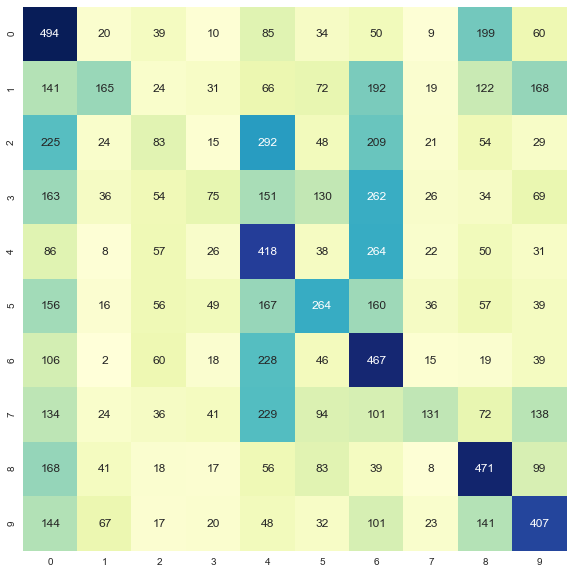

In [109]:
plt.figure(figsize=(10,10))
confusion_matrix_data = confusion_matrix(cifar10_test["class"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

## 3.3 Naive Bayes on fashion MNIST

In [155]:
model2 = NaiveBayes()
X_train = fashion_mnist_train.drop(columns="label").as_matrix() / 255
y_train = fashion_mnist_train["label"].as_matrix()
model2.fit(X_train, y_train)

In [156]:
import time
start = time.time()
X_test = fashion_mnist_test.drop(columns="label").as_matrix() / 255
y_pred = model2.predict(X_test, True)
print("Prediction completed. Duration: %.1fs" % (time.time() - start))

Prediction completed. Duration: 2.5s


In [157]:
print("The accuracy of the model is: %.2f%%" % ((fashion_mnist_test["label"] == y_pred[:,0]).sum() / len(fashion_mnist_test) * 100))
print("The log-likelihood is: %.2f" % y_pred[:,1].sum())
loglik_corrects = np.array([y_pred[i][1] for i in range(len(y_pred)) if y_pred[i][0] == fashion_mnist_test["label"].iloc[i]])
print("The average log-likelihood for correct predictions is: %.2f" % loglik_corrects.mean())
loglik_errors = np.array([y_pred[i][1] for i in range(len(y_pred)) if y_pred[i][0] != fashion_mnist_test["label"].iloc[i]])
print("The average log-likelihood for wrong predictions is: %.2f" % loglik_errors.mean())

The accuracy of the model is: 60.20%
The log-likelihood is: 2894875.35
The average log-likelihood for correct predictions is: 308.63
The average log-likelihood for wrong predictions is: 260.54


<div class="alert alert-warning">
We get <b>positive likelihoods</b> because of scaling factor. Having (sometimes) small standard deviations at the denominator of the log argument, we obtain positive values. Of course this fact doesn't change the general meaning of our discussion, which analyze these values relatively to the others.
</div>

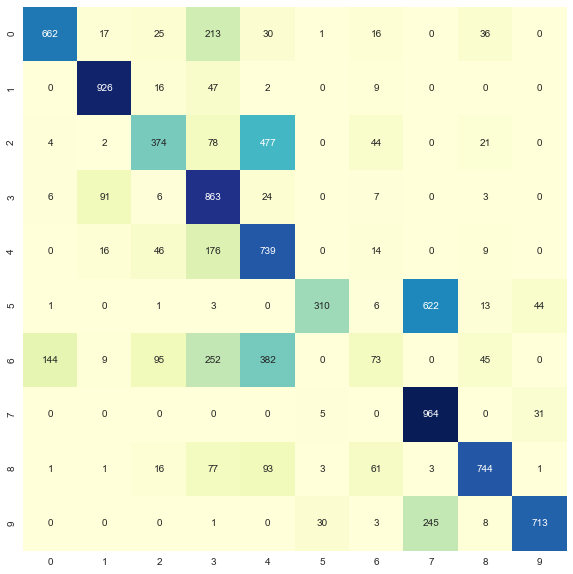

In [17]:
plt.figure(figsize=(10,10))
confusion_matrix_data = confusion_matrix(fashion_mnist_test["label"], y_pred[:,0])
ax = sns.heatmap(confusion_matrix_data, annot=True, cbar=False, square=True, fmt='d', cmap="YlGnBu")

## 3.4 Discussion of performances

### 3.4.1 Comparison with random classifier

In [18]:
random_y_pred_cifar = np.random.randint(low=0, high=10, size=len(cifar10_test))
random_y_pred_mnist = np.random.randint(low=0, high=10, size=len(fashion_mnist_test))
print("The accuracy of random model for Fashion MNIST is: %.2f%%" % ((fashion_mnist_test["label"] == random_y_pred_mnist).sum() / len(fashion_mnist_test) * 100))
print("The accuracy of random model for CIFAR-10 is: %.2f%%" % ((cifar10_test["class"] == random_y_pred_mnist).sum() / len(cifar10_test) * 100))

The accuracy of random model for Fashion MNIST is: 10.18%
The accuracy of random model for CIFAR-10 is: 9.51%


<div class="alert alert-success">
<b>Random classifier comparison</b><br>
Of course the accuracy of random classifier is really poor. The accuracy is about 10%, the same result we would obtain if we predict always the same class. We obtained better result but not so much, especially in the case of CIFAR-10 dataset where the accuracy is only about 30%.
</div>

### 3.4.2 Suggestions to improve

<div class="alert alert-success">
In general we didn't obtain good results. From this fact we can say that it is possible that the independence between features is not true in this case (and if you think about, it is reasonable to think that pixels are correlated). Essentialy we should use a model that doesn't make this assumption. In the pre-processing discussion we mentioned LDA about dimensionality reduction. Indeed this model is composed by two stages: dimensionality reduction and classification stage. And about the classification stage even in this case we use the Bayes rule as Naïve classifier. Both are called "generative" models because they estimate the posterior. But in this case we don't have the independence assumption and we suppose that classes are linearly separable. We can easily try the performance of LDA thanks to sklearn library.
</div>

In [19]:
clf = LinearDiscriminantAnalysis()
X_train = fashion_mnist_train.drop(columns="label").as_matrix()
y_train = fashion_mnist_train["label"].as_matrix()
X_test = fashion_mnist_test.drop(columns="label").as_matrix()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy for MNIST: %.2f%%" % ((fashion_mnist_test["label"] == y_pred).sum() / len(fashion_mnist_test) * 100))

Accuracy for MNIST: 82.56%


In [20]:
clf2 = LinearDiscriminantAnalysis()
X_train = cifar10_train.drop(columns="class").as_matrix()
y_train = cifar10_train["class"].as_matrix()
X_test = cifar10_test.drop(columns="class").as_matrix() 
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
print("Accuracy for CIFAR-10: %.2f%%" % ((cifar10_test["class"] == y_pred).sum() / len(cifar10_test) * 100))

Accuracy for CIFAR-10: 37.13%


<div class="alert alert-success">
Our suggestions are true especially for the MNIST dataset: the accuracy is really good, so much better than before (63.68%). We can't say the same with regards to CIFAR-10 dataset: we actually improved the accuracy (with Naïve we got 29.32%) but it remains low anyway. Probably in this case we have a more difficult classification problem and we have poor performaces because classes are not linearly separable.
</div>

# 4 Linear regression

In [123]:
def get_w_hat(X_, y):  
    #w_hat = (np.linalg.inv(X_.T.dot(X_))).dot(X_.T).dot(np.array(y)) 
    w_hat = np.linalg.solve(X_.T.dot(X_), X_.T.dot(np.array(y)))
    return w_hat

def get_sigma2_hat(X, w_hat, t):
    sigma2_hat = (t - X.dot(w_hat)).T.dot(t - X.dot(w_hat)) / len(X)
    return sigma2_hat

def get_cov_w_hat(sigma2_hat, X):
    cov_w_hat = sigma2_hat * np.linalg.inv(X.T.dot(X))
    return cov_w_hat

In [175]:
X_train = fashion_mnist_train.drop(columns="label").as_matrix() / 255
X_train_one = np.ones((len(X_train), len(X_train[0])+1))
X_train_one[:,:-1] = X_train
y_train = fashion_mnist_train["label"].as_matrix()
X_test = fashion_mnist_test.drop(columns="label").as_matrix() / 255
X_test_one = np.ones((len(X_test), len(X_test[0])+1))
X_test_one[:,:-1] = X_test
w_hat = get_w_hat(X_train_one, y_train)
sigma2_hat = get_sigma2_hat(X_train_one, w_hat, y_train)
cov_w_hat = get_cov_w_hat(sigma2_hat, X_train_one)
predictions = X_test_one.dot(w_hat)
print(mean_squared_error(fashion_mnist_test["label"], predictions))

sigma2_new = np.zeros(len(X_test_one))
for i in range(len(X_test_one)):
    x_new = X_test_one[i,:]
    sigma2_new[i] = x_new.dot(cov_w_hat).dot(x_new.T)

1.963856819494109


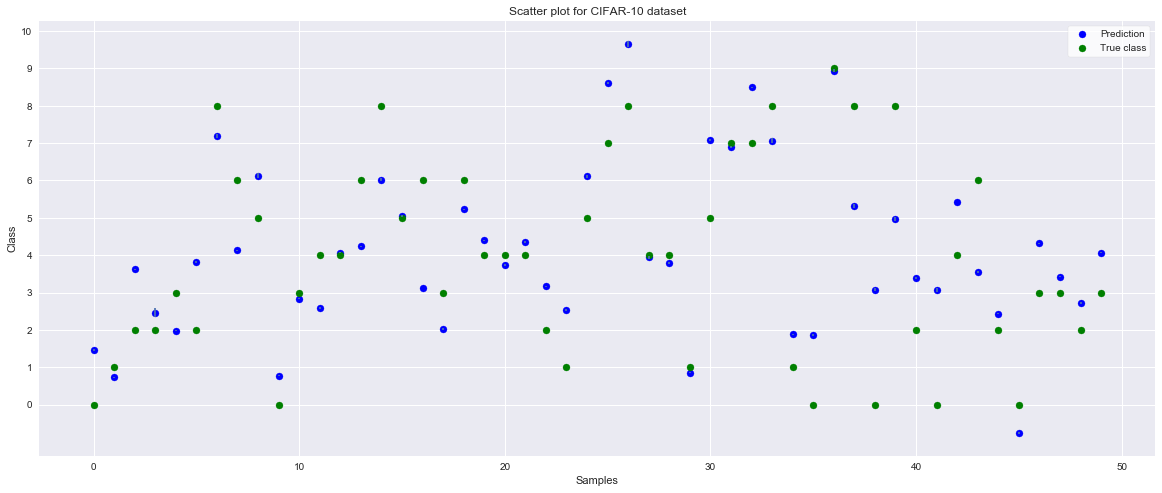

In [179]:
plt.figure(figsize=(20,8))
plt.yticks(list(range(11)))
plt.scatter(list(range(50)), predictions[:50], color="blue")
plt.scatter(list(range(50)), fashion_mnist_test["label"][:50], color="green")
plt.errorbar(list(range(50)), predictions[:50], yerr=sigma2_new[:50], fmt='none')
plt.legend(["Prediction", "True class"], frameon=True, fancybox=True, facecolor='w')
plt.title("Scatter plot for CIFAR-10 dataset")
plt.ylabel("Class")
plt.xlabel("Samples")
plt.show()

In [170]:
X_train = cifar10_train.drop(columns="class").as_matrix() / 255
X_train_one = np.ones((len(X_train), len(X_train[0])+1))
X_train_one[:,:-1] = X_train
y_train = cifar10_train["class"].as_matrix()
X_test = cifar10_test.drop(columns="class").as_matrix() / 255
X_test_one = np.ones((len(X_test), len(X_test[0])+1))
X_test_one[:,:-1] = X_test
w_hat = get_w_hat(X_train_one, y_train)
sigma2_hat = get_sigma2_hat(X_train_one, w_hat, y_train)
cov_w_hat = get_cov_w_hat(sigma2_hat, X_train_one)
predictions = X_test_one.dot(w_hat)
print(mean_squared_error(fashion_mnist_test["label"], predictions))

sigma2_new = np.zeros(len(X_test_one))
for i in range(len(X_test_one)):
    x_new = X_test_one[i,:]
    sigma2_new[i] = x_new.dot(cov_w_hat).dot(x_new.T)

9.562931922945962


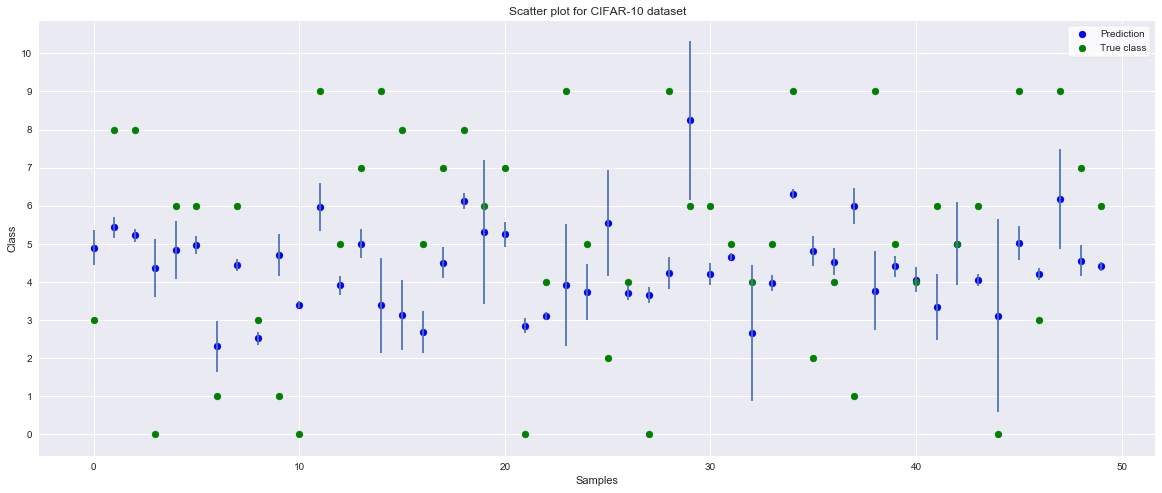

In [173]:
plt.figure(figsize=(20,8))
plt.yticks(list(range(11)))
plt.scatter(list(range(50)), predictions[:50], color="blue")
plt.scatter(list(range(50)), cifar10_test["class"][:50], color="green")
plt.errorbar(list(range(50)), predictions[:50], yerr=sigma2_new[:50], fmt='none')
plt.legend(["Prediction", "True class"], frameon=True, fancybox=True, facecolor='w')
plt.title("Scatter plot for CIFAR-10 dataset")
plt.ylabel("Class")
plt.xlabel("Samples")
plt.show()